# HOOPS AI: Use the Dataset Explorer to navigate the dataset


The `dataset` module provides a comprehensive framework for exploring, navigating, and loading CAD model datasets for machine learning applications. It consists of two primary components that work together to simplify data handling:

1. **DatasetExplorer** - For exploring and querying dataset contents
2. **DatasetLoader** - For loading and preparing datasets for machine learning training

These components are designed to work with the processed data from the `cadaccess` and `cadencoder` modules, as well as the outputs from the flow pipeline system. They provide high-level abstractions that allow users to focus on machine learning tasks rather than data handling complexities.

## DatasetExplorer

The `DatasetExplorer` class (`dataset_explorer.py`) provides methods for exploring and querying datasets stored in Zarr format (.dataset) with accompanying metadata (.infoset) in Parquet files. This class focuses on data discovery, filtering, and statistical analysis.

### Key Methods

#### Data Discovery and Metadata

- `available_groups() -> set`: Returns the set of available dataset groups (faces, edges, file, etc.)
- `get_descriptions(table_name: str, key_id: Optional[int] = None, use_wildchar: Optional[bool] = False) -> pd.DataFrame`: Retrieves metadata descriptions (labels, face types, edge types, etc.)
- `get_parquet_info_by_code(file_id_code: int)`: Returns rows from the Parquet file for a specific file ID code
- `get_file_info_all() -> pd.DataFrame`: Returns all file info from the Parquet metadata

#### Data Distribution Analysis

- `create_distribution(key: str, bins: int = 10, group: str = "faces") -> Dict[str, Any]`: Computes histograms of data distributions using Dask for parallel processing

#### Data Filtering and Selection

- `get_file_list(group: str, where: Callable[[xr.Dataset], xr.DataArray]) -> List[str]`: Returns file IDs matching a boolean filter condition
- `file_dataset(file_id_code: int, group: str) -> xr.Dataset`: Returns a subset of the dataset for a specific file
- `build_membership_matrix(group: str, key: str, bins_or_categories: Union[int, List, np.ndarray], as_counts: bool = False) -> tuple[np.ndarray, np.ndarray, np.ndarray]`: Builds a file-by-bin membership matrix for stratified splitting
- `decode_file_id_code(code: int) -> str`: Converts an integer file ID code to the original string identifier

In [1]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license())

ℹ️ Using TEST LICENSE (expires December 8, 2025 - 37 days remaining)
   For production use, obtain your own license from Tech Soft 3D
✓ HOOPS AI License: Valid (TEST LICENSE - expires Dec 6, 2025)


In [2]:
from hoops_ai.dataset import DatasetExplorer
import pathlib 
# Define paths
flow_name = "cadsynth_aag"

flow_root_dir = pathlib.Path.cwd().parent.joinpath("packages", "flows", flow_name)
print(flow_root_dir)

parquet_file_path        = str(flow_root_dir.joinpath(f"{flow_name}.infoset"))
merged_store_path     = str(flow_root_dir.joinpath(f"{flow_name}.dataset"))
parquet_file_attribs  = str(flow_root_dir.joinpath(f"{flow_name}.attribset"))


explorer = DatasetExplorer(merged_store_path=merged_store_path, parquet_file_path=parquet_file_path, parquet_file_attribs=parquet_file_attribs)
#explorer.print_table_of_contents()

C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\packages\flows\cadsynth_aag
[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:57953' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/162412 [00:00<?, ?it/s]

In [3]:
groups = explorer.available_groups()
print(groups)

{'faceface', 'faces', 'file', 'edges', 'graph'}


In [4]:
face_type_description = explorer.get_descriptions("face_types")
print(type(face_type_description), face_type_description)

<class 'pandas.core.frame.DataFrame'>    id        name description  table_name
0   0       Plane     not set  face_types
1   1    Cylinder     not set  face_types
2   2        Cone     not set  face_types
3  14   Extrusion     not set  face_types
4   3      Sphere     not set  face_types
5   4       Torus     not set  face_types
6   5       Nurbs     not set  face_types
7  13  Revolution     not set  face_types


In [5]:
# Get and print meta data information
file_id = 25
df_info = explorer.get_parquet_info_by_code(file_id)
print(type(df_info), df_info)

<class 'pandas.core.frame.DataFrame'>                                name                             description  \
0  0007c9b910d876090f12c2cad80794df  C:\Temp\Cadsynth_aag\step\00035533.stp   

  subset  id table_name  
0  train  25  file_info  


In [6]:
# Access various dataset groups
file_datasetGroup = {grp: explorer.file_dataset(file_id_code=file_id, group=grp) for grp in groups}

print(f"Datasets (Table of Content) for file ID '{file_id}':")
for grp, ds in file_datasetGroup.items():
    for name, da in ds.data_vars.items():
        print(f"  [{grp}] DATA: {name}, Shape: {da.shape}, Dims: {da.dims}, Size: {da.size}")
print()

file_dataset = file_datasetGroup["faces"]
print("type of file_data_arrays", type(file_dataset))

#print the areas of each face
array_areas = file_dataset["face_areas"].data.compute()
print("type of array_areas", type(array_areas))
print("brep surfaces", array_areas.shape)

Datasets (Table of Content) for file ID '25':
  [faceface] DATA: a3_distance, Shape: (2025, 64), Dims: ('faceface_flat', 'bins_d'), Size: 129600
  [faceface] DATA: d2_distance, Shape: (2025, 64), Dims: ('faceface_flat', 'bins_a'), Size: 129600
  [faceface] DATA: extended_adjacency, Shape: (2025,), Dims: ('faceface_flat',), Size: 2025
  [faceface] DATA: face_pair_edges_path, Shape: (2025, 32), Dims: ('faceface_flat', 'dim_path'), Size: 64800
  [faceface] DATA: face_x, Shape: (2025,), Dims: ('faceface_flat',), Size: 2025
  [faceface] DATA: face_y, Shape: (2025,), Dims: ('faceface_flat',), Size: 2025
  [faceface] DATA: file_id_code_faceface, Shape: (2025,), Dims: ('faceface_flat',), Size: 2025
  [faces] DATA: face_areas, Shape: (45,), Dims: ('face',), Size: 45
  [faces] DATA: face_indices, Shape: (45,), Dims: ('face',), Size: 45
  [faces] DATA: face_labels, Shape: (45,), Dims: ('face',), Size: 45
  [faces] DATA: face_loops, Shape: (45,), Dims: ('face',), Size: 45
  [faces] DATA: face_neig

In [7]:
# this requires to be a bit familiar with pandas and dask.
uv_grid_data = file_dataset["face_uv_grids"].data.compute()


print("numpy array shape", uv_grid_data.shape)

numpy array shape (45, 5, 5, 7)


In [8]:
#print(uv_grid_data)

In [9]:
explorer.get_file_info_all()

name  \
0       00001d44b8eb37fe4bb6ec4e89746ea3   
1       000093c3b74c8076fbba20bf8613e2a2   
2       00012dc0e22bd178d7c6a12436734130   
3       00013001df401fe06d5213ef6fc9e581   
4       00015d0e0e285c5089a485360b34db1a   
...                                  ...   
162407  fffe278b406958997fff4c1f76b72ee0   
162408  fffe3fba779b5fa5543c4a82c3cfbabb   
162409  fffee3edd46107ca808a958811dcb9a8   
162410  ffff1ac0abc28d3ede6b7bfb6434cdf4   
162411  ffffdc1d0cb629065026fa55a97ca314   

                                              description      subset      id  \
0                  C:\Temp\Cadsynth_aag\step\00021388.stp       train       0   
1       C:\Temp\Cadsynth_aag\step\20221121_154647_2127...  validation       1   
2                  C:\Temp\Cadsynth_aag\step\00067737.stp  validation       2   
3                  C:\Temp\Cadsynth_aag\step\00058353.stp  validation       3   
4                  C:\Temp\Cadsynth_aag\step\00048571.stp       train       4   
...                                                   ...         ...     ...   
162407  C:\Temp\Cadsynth_aag\step\20221123_142528_2390...        test  162407   
162408             C:\Temp\Cadsynth_aag\step\00091954.stp       train  162408   
162409  C:\Temp\Cadsynth_aag\step\20221124_154714_1362...  validation  162409   
162410             C:\Temp\Cadsynth_aag\step\00065860.stp       train  162410   
162411             C:\Temp\Cadsynth_aag\step\00016373.stp       train  162411   

       table_name  
0       file_info  
1       file_info  
2       file_info  
3       file_info  
4       file_info  
...           ...  
162407  file_info  
162408  file_info  
162409  file_info  
162410  file_info  
162411  file_info  

[162412 rows x 5 columns]

In [10]:
# Visualization libraries
import matplotlib.pyplot as plt

def print_distribution_info(dist, title="Distribution"):
    """Helper function to print and visualize distribution data."""
    list_filecount = list()
    for i, bin_files in enumerate(dist['file_id_codes_in_bins']):
        list_filecount.append(bin_files.size)

    dist['file_count'] =list_filecount
    # Visualization with matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bin_centers = 0.5 * (dist['bin_edges'][1:] + dist['bin_edges'][:-1])
    ax.bar(bin_centers, dist['file_count'], width=(dist['bin_edges'][1] - dist['bin_edges'][0]), 
           alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
    
    # Add file count annotations
    for i, count in enumerate(dist['file_count']):
        if count > 0:  # Only annotate non-empty bins
            ax.text(bin_centers[i], count + 0.5, f"{count}", 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Histogram')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Face labels distribution created in 2.31 seconds



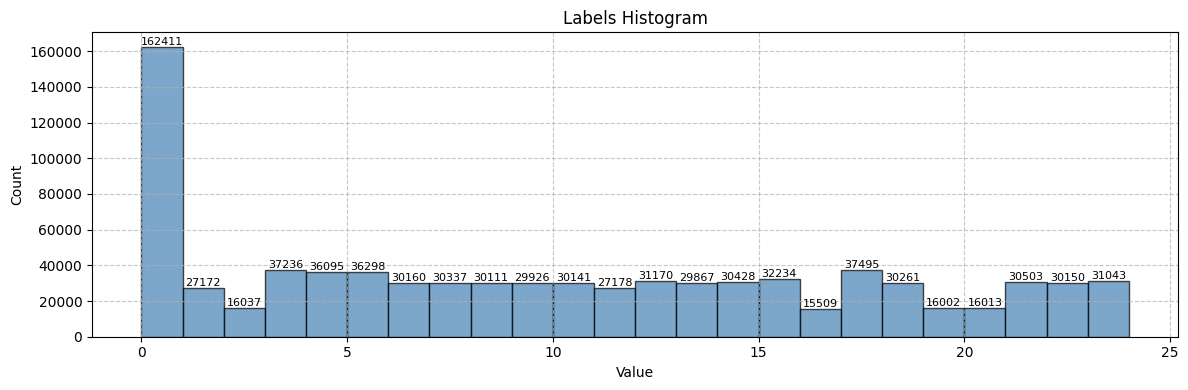

In [11]:
import time
start_time = time.time()
face_dist = explorer.create_distribution(key="face_labels", bins=None, group="faces")
print(f"Face labels distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Labels")


In [12]:
print(explorer.get_descriptions("face_labels"))

    id                                name description   table_name
14   0                            no-label     not set  face_labels
15   7                 2sides_through_step     not set  face_labels
16  11              rectangular_blind_slot     not set  face_labels
17  18                 circular blind step     not set  face_labels
18   5                      6sides_passage     not set  face_labels
19   9              rectangular_blind_step     not set  face_labels
20  12                  rectangular_pocket     not set  face_labels
21  13                   triangular_pocket     not set  face_labels
22  14                       6sides_pocket     not set  face_labels
23  21                 circular end pocket     not set  face_labels
24  23                          blind hole     not set  face_labels
25   2             triangular_through_slot     not set  face_labels
26  17                        through hole     not set  face_labels
27   3                 rectangular_passage     n

Face labels distribution created in 4.20 seconds



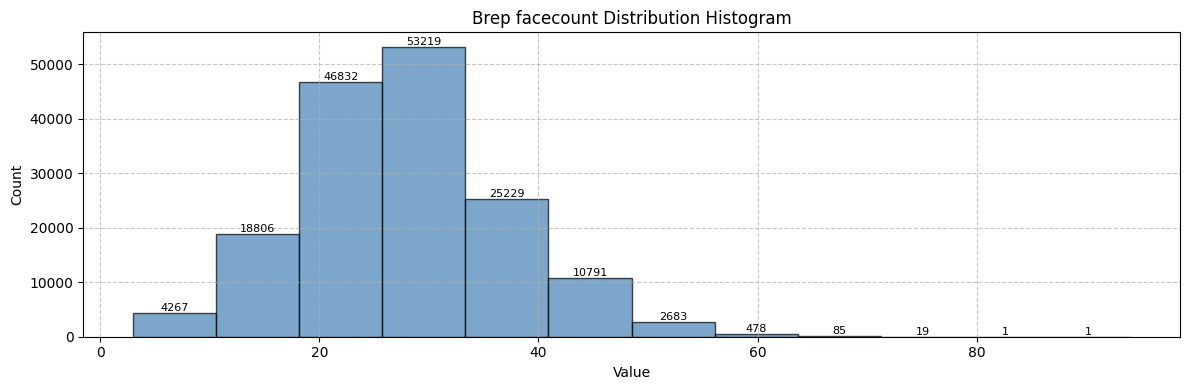

In [13]:
start_time = time.time()
dist = explorer.create_distribution(key="num_nodes", bins=12, group="graph")
print(f"Face labels distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(dist, title="Brep facecount Distribution")

# Gather files that fulfilled a given condition. Filter

In [14]:
start_time = time.time()

# condition
label_is_pipefittings = lambda ds: ds['face_labels'] == 15

filelist = explorer.get_file_list(group="faces", where=label_is_pipefittings)
print(f"Filtering completed in {(time.time() - start_time):.2f} seconds")
print(f"Found {len(filelist)} files with face_labels == 15 (chamfer)\n")
print(filelist)

Filtering completed in 0.21 seconds
Found 32234 files with face_labels == 15 (chamfer)

[    10     12     15 ... 162392 162398 162401]


# Query data for single file

In [15]:
def demo_query_single_file(explorer, file_id):
    """Show how to access and query dataset details for a single file."""
    print("=== Single File Dataset Access ===")
    import time
    # Get and print parquet info
    df_info = explorer.get_parquet_info_by_code(file_id)
    print("Files info:")
    for column in df_info.columns:
        print(f"Column: {column}")
        for value in df_info[column]:
            print(f"  {value}")
    print()

    # Access various dataset groups
    groups = ["faces", "file", "edges", "graph"]
    datasets = {grp: explorer.file_dataset(file_id_code=file_id, group=grp) for grp in groups}

    print(f"Datasets for file ID '{file_id}':")
    for grp, ds in datasets.items():
        for name, da in ds.data_vars.items():
            print(f"  [{grp}] VARIABLE: {name}, Shape: {da.shape}, Dims: {da.dims}, Size: {da.size}")
    print()

    # Query uv grids data for a specific face
    start_time = time.time()
    uv_grid_data = datasets["faces"]["face_uv_grids"].isel(face=2)
    print("uv_grids data for face index 2:")
    np_uvgrid = uv_grid_data.data.compute()
    print(f"Query took {(time.time() - start_time):.2f} seconds\n")

In [16]:
demo_query_single_file(explorer,file_id=4500)

=== Single File Dataset Access ===
Files info:
Column: name
  07207dfd094fe0ebe9368ded4c271b23
Column: description
  C:\Temp\Cadsynth_aag\step\20221124_154714_17096.step
Column: subset
  test
Column: id
  4500
Column: table_name
  file_info

Datasets for file ID '4500':
  [faces] VARIABLE: face_areas, Shape: (38,), Dims: ('face',), Size: 38
  [faces] VARIABLE: face_indices, Shape: (38,), Dims: ('face',), Size: 38
  [faces] VARIABLE: face_labels, Shape: (38,), Dims: ('face',), Size: 38
  [faces] VARIABLE: face_loops, Shape: (38,), Dims: ('face',), Size: 38
  [faces] VARIABLE: face_neighborscount, Shape: (38,), Dims: ('face',), Size: 38
  [faces] VARIABLE: face_types, Shape: (38,), Dims: ('face',), Size: 38
  [faces] VARIABLE: face_uv_grids, Shape: (38, 5, 5, 7), Dims: ('face', 'uv_x', 'uv_y', 'component'), Size: 6650
  [faces] VARIABLE: file_id_code_faces, Shape: (38,), Dims: ('face',), Size: 38
  [file] VARIABLE: duration_dglconvert, Shape: (1,), Dims: ('file',), Size: 1
  [file] VARIA

# Create subsets (train, validation, test) based on the label distribution

In [17]:

def demo_stratified_splits(explorer):
    """Show building a membership matrix and performing stratified splits."""
    print("=== Membership Matrix and Data Splitting ===")
    
    import time
    from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
    import numpy as np
    start_time = time.time()

    df_label = explorer.get_descriptions("label", None, True)
    label_key = df_label["table_name"].iloc[0]

    if label_key == "file_label":
        group = "file"
    else:
        group = "faces"

    matrix, file_codes, _ = explorer.build_membership_matrix(group=group, key=label_key, bins_or_categories=None, as_counts=False)

    # First split: 70% train, 30% temporary
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    for train_idx, temp_idx in msss.split(np.arange(len(matrix))[:, None], matrix):
        pass

    # Second split on the temporary set into 50% validation, 50% test => 15% each overall
    msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
    for val_sub, test_sub in msss2.split(np.arange(len(temp_idx))[:, None], matrix[temp_idx]):
        val_idx = temp_idx[val_sub]
        test_idx = temp_idx[test_sub]

    print("Train file IDs:", file_codes[train_idx].shape)
    print("Validation file IDs:", file_codes[val_idx].shape)
    print("Test file IDs:", file_codes[test_idx].shape)
    print(f"Stratified Splitting completed in {(time.time() - start_time):.2f} seconds")
    print()

In [18]:
demo_stratified_splits(explorer)

=== Membership Matrix and Data Splitting ===
Train file IDs: (113479,)
Validation file IDs: (24453,)
Test file IDs: (24480,)
Stratified Splitting completed in 15.14 seconds

